<a href="https://colab.research.google.com/github/DaryaTereshchenko/HateSpeechDetection/blob/dev_01/ROBERTA_toy_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install sentence_transformers
!pip install transformers

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import tensorflow as tf
from sentence_transformers import SentenceTransformer
from transformers import RobertaTokenizer

In [ ]:
from transformers import RobertaTokenizer, RobertaConfig, TFRobertaPreTrainedModel
from transformers import TFRobertaMainLayer
from transformers.modeling_tf_utils import get_initializer

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout, Input, GlobalMaxPooling1D, LSTM, GRU
from tensorflow.keras.layers import Embedding

In [ ]:
from tensorflow.keras.models import Sequential

In [ ]:
# resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
# tf.config.experimental_connect_to_cluster(resolver)
# tf.tpu.experimental.initialize_tpu_system(resolver)

In [ ]:
ethos_hate = pd.read_csv("ethos_hate.csv", sep=",", encoding="unicode_escape").drop(columns="label")
ethos_hate["label"] = 1

ethos_neutral = pd.read_csv("ethos_neutral.csv", sep=",", encoding="unicode_escape").drop(columns="label")
ethos_neutral["label"] = 0

train_n = ethos_neutral.sample(frac=0.9, random_state=0)
test_n = ethos_neutral.drop(train_n.index)

train_hate = ethos_hate.sample(frac=0.9, random_state=0)
test_hate = ethos_hate.drop(train_hate.index)


train = pd.concat([train_n, train_hate]).sample(frac=1, random_state=300).reset_index(drop=True)
test = pd.concat([test_n, test_hate]).sample(frac=1, random_state=300).reset_index(drop=True)

print(train.text[0])


What episode number was this?


In [ ]:
print(test.label)

0     0
1     1
2     0
3     1
4     0
     ..
95    0
96    1
97    0
98    1
99    1
Name: label, Length: 100, dtype: int64


In [ ]:
train.head

<bound method NDFrame.head of                                                   text  label
0                        What episode number was this?      0
1    Why don't you go beck your god to murder you? ...      1
2    I don't like jew soap, but if we are to get ri...      1
3    By calling period, a natural procedure, as an ...      1
4       MASS BLACK WORLDWIDE GENOCIDE IS OUR ONLY HOPE      1
..                                                 ...    ...
893  Is this world filled by those stupid female bi...      1
894                 What type of question it is???????      0
895                  Die fucking arab dude sand niggas      1
896             Japanese culture is ancient and unique      0
897  People who say "YAAAASSSS QUEEN" should be ste...      0

[898 rows x 2 columns]>

In [ ]:
def clean_text(line):
  stops = set(stopwords.words("english"))
  processed_line = line.lower()
  words = [word for word in word_tokenize(processed_line)]
  processed_line = [word for word in words if word not in stops 
                    and word not in set(string.punctuation)]
  text = " ".join(processed_line)
  return text

In [ ]:
# Sentences for embeddings
train_sentence_list = list(map(clean_text, train.text.values))
test_sentence_list = list(map(clean_text, test.text.values))

In [ ]:
train_sentence_list

In [ ]:
MODEL_NAME = 'roberta-base'
MAX_LEN = 128

tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
def to_tokens(input_text, tokenizer):
    output = tokenizer.encode_plus(input_text, max_length=MAX_LEN, padding="max_length", truncation=True)
    return output

def select_field(output, field):
  ls = []
  for dictionary in output:
    ls.append(np.array(dictionary[field]))
  return ls 


In [ ]:
tokenizer_output_train = [to_tokens(sent, tokenizer)  for sent in train_sentence_list]
tokenizer_output_test = [to_tokens(sent, tokenizer)  for sent in test_sentence_list]

In [ ]:
tokenizer_output_train


In [ ]:
input_ids_train = np.array(select_field(tokenizer_output_train, 'input_ids'))
attention_masks_train = np.array(select_field(tokenizer_output_train, 'attention_mask'))

In [ ]:
input_ids_train = tf.cast(input_ids_train , dtype=tf.float32)
attention_masks_train = tf.cast(attention_masks_train , dtype=tf.float32)

In [ ]:
input_ids_test = np.array(select_field(tokenizer_output_test, 'input_ids'))
attention_masks_test = np.array(select_field(tokenizer_output_test, 'attention_mask'))

In [ ]:
input_ids_test = tf.cast(input_ids_test , dtype=tf.float32)
attention_masks_test = tf.cast(attention_masks_test , dtype=tf.float32)

In [ ]:
attention_masks_test

**MODEL**


In [ ]:
X_test, y_test = input_ids_test + attention_masks_test, np.array(test.label).reshape(-1,1)

In [ ]:
X_train, y_train = input_ids_train + attention_masks_train, np.array(train.label).reshape(-1,1)

In [ ]:
max_features = 120000

In [ ]:
def compile_and_run(model, epochs):
    model.compile(loss=tf.keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])
    print(model.layers)
    model.summary()
    batch_size = 128
    model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(X_test, y_test))
    score = model.evaluate(X_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    return tf.keras.utils.plot_model(model)

In [ ]:
model1 = Sequential()
model1.add()
model1.add(Dense(1, activation='sigmoid'))


Epoch 1/7
8/8 [==============================] - 1s 22ms/step - loss: 1320.0721 - accuracy: 0.5312 - val_loss: 1168.5062 - val_accuracy: 0.5500
Epoch 2/7
8/8 [==============================] - 0s 6ms/step - loss: 1244.0515 - accuracy: 0.5323 - val_loss: 1121.1460 - val_accuracy: 0.5500
Epoch 3/7
8/8 [==============================] - 0s 6ms/step - loss: 1183.1974 - accuracy: 0.5334 - val_loss: 1089.5576 - val_accuracy: 0.5500
Epoch 4/7
8/8 [==============================] - 0s 6ms/step - loss: 1134.9302 - accuracy: 0.5345 - val_loss: 1056.9530 - val_accuracy: 0.5600
Epoch 5/7
8/8 [==============================] - 0s 6ms/step - loss: 1091.2206 - accuracy: 0.5390 - val_loss: 1025.6187 - val_accuracy: 0.5700
Epoch 6/7
8/8 [==============================] - 0s 6ms/step - loss: 1053.5453 - accuracy: 0.5367 - val_loss: 994.2054 - val_accuracy: 0.5700
Epoch 7/7
8/8 [==============================] - 0s 6ms/step - loss: 1012.8049 - accuracy: 0.5379 - val_loss: 959.9249 - val_accuracy: 0.5700


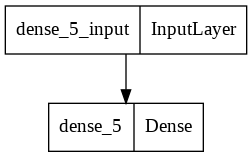

In [ ]:
compile_and_run(model, 7)